# Fruits Dataset

### _Extract Data_

In [61]:
import os
import numpy as np
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

In [62]:
fruits = []
labels = [] 
fruits_f = []
for fruit_dir in glob.glob("fruits/Training/*"):
    fruit_dir = fruit_dir.replace('\\', '/')
    fruit_label = fruit_dir.split("/")[-1]
    for img in glob.glob(os.path.join(fruit_dir, "*.jpg")):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (45, 45))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        imgf = np.reshape(img,(45*45,3))
        fruits.append(img)
        fruits_f.append(imgf)
        labels.append(fruit_label)
fruits = np.array(fruits)
labels = np.array(labels)
fruits_f = np.array(fruits_f)
print(fruits.shape,labels.shape)
print(labels)

(1470, 45, 45, 3) (1470,)
['Banana' 'Banana' 'Banana' ... 'Pineapple' 'Pineapple' 'Pineapple']


In [68]:
id_to_labels = {i:v for i,v in enumerate(np.unique(labels))}
print(id_to_labels)
label_to_ids = {v:i for i,v in id_to_labels.items()}
label_ids = np.array([label_to_ids[x] for x in labels])
label_names = [v for i,v in id_to_labels.items()]
print(label_ids)

{0: 'Banana', 1: 'Limes', 2: 'Pineapple'}
[0 0 0 ... 2 2 2]


In [69]:
import numpy.linalg as la
images = np.array([i.flatten() for i in fruits])
print(images.shape)
m = np.mean(images)
im_bar = images - m

(1470, 6075)


Text(0,0.5,'Y (log scale)')

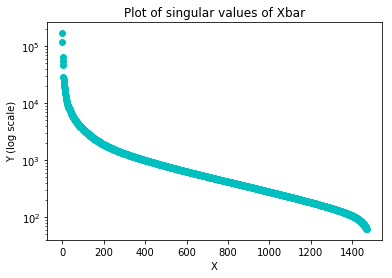

In [70]:
im_bar = im_bar.transpose()
%matplotlib inline
import matplotlib.pyplot as plt
U,s,VT = la.svd(im_bar)
fig = plt.figure()
x = np.arange(s.shape[0])
y = s
ax = fig.add_subplot(111)
plt.yscale('log')
ax.scatter(x, y, c='c', marker='o')
ax.set_title("Plot of singular values of Xbar")
ax.set_xlabel('X')
ax.set_ylabel('Y (log scale)')

In [71]:
#im_bar = im_bar.transpose()
#finding smallest k to encompass 90% of data
s_sum = 0
fnorm = la.norm(im_bar)**2

k = 0
for i in range(s.shape[0]):
    s_sum = s_sum + s[i]**2
    t = s_sum/fnorm
    if(t >= 0.964):
        k = i
        break
#top k principal components of Xbar

print("k is: ",k)

k is:  51


(51, 1470)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6075, 1470)


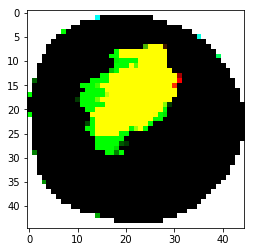

In [77]:
Uk = U[:,0:k]
features = Uk.transpose()@im_bar
print(features.shape)
recon = Uk@Uk.transpose()@im_bar
print(recon.shape)
r = np.random.randint(0,im_bar.shape[1])
img = np.reshape(recon[:,r],(45,45,3))
plt.imshow(img)

### Sklearn PCA

In [10]:
scaler = StandardScaler()
images_scaled = scaler.fit_transform([i.flatten() for i in fruits])
print(images_scaled.shape)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

(1470, 6075)


In [11]:
print(pca_result.shape)

(1470, 50)


(1470, 2)


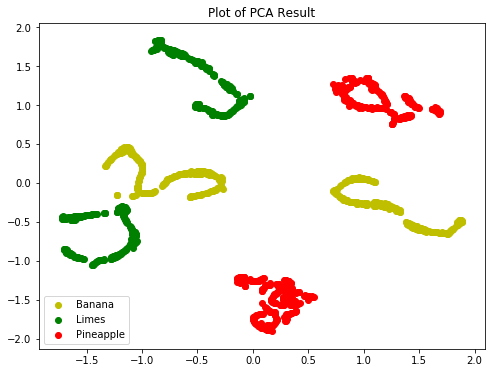

In [12]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print(tsne_result_scaled.shape)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)

for i in range(tsne_result_scaled.shape[0]):
    if (label_ids[i]==0):
        zerop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='y', marker='o')
    if (label_ids[i]==1):
        onep = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='g', marker='o')
    if (label_ids[i]==2):
        twop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='r', marker='o')
ax.set_title("Plot of PCA Result")
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([zerop,onep,twop], ["Banana","Limes","Pineapple"],loc=3)
plt.show()

## Split into Training and Test Data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

#### Train Model

In [39]:
svm_clf = svm.SVC()
svm_clf = svm_clf.fit(X_train, y_train) 

In [40]:
test_predictions = svm_clf.predict(X_test)

In [41]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Training Accuracy with SVM: {0:.6f}".format(precision))

Training Accuracy with SVM: 94.293478


In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(test_predictions, y_test,target_names=label_names))
print(confusion_matrix(test_predictions, y_test, labels=range(3)))

             precision    recall  f1-score   support

     Banana       0.83      1.00      0.91       103
      Limes       1.00      1.00      1.00       117
  Pineapple       1.00      0.86      0.92       148

avg / total       0.95      0.94      0.94       368

[[103   0   0]
 [  0 117   0]
 [ 21   0 127]]


### Test SVM Model on Validation Data

In [43]:
val_fruits = []
val_labels = [] 
val_fruits_f = []
for fruit_dir in glob.glob("fruits/Test/*"):
    fruit_dir = fruit_dir.replace('\\', '/')
    fruit_label = fruit_dir.split("/")[-1]
    for img in glob.glob(os.path.join(fruit_dir, "*.jpg")):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (45, 45))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        imgf = np.reshape(img,(45*45,3))
        val_fruits.append(img)
        val_fruits_f.append(imgf)
        val_labels.append(fruit_label)
val_fruits = np.array(val_fruits)
val_labels = np.array(val_labels)
val_fruits_f = np.array(val_fruits_f)
print(val_fruits.shape,val_labels.shape)

(498, 45, 45, 3) (498,)


In [44]:
val_label_ids = np.array([label_to_ids[i] for i in val_labels])
val_images_scaled = scaler.transform([i.flatten() for i in val_fruits])
val_pca_res = pca.transform(val_images_scaled)
print(val_pca_res.shape)

(498, 50)


(498, 2)


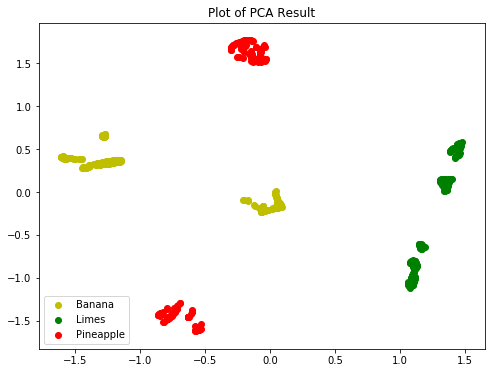

In [45]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(val_pca_res)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print(tsne_result_scaled.shape)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)

for i in range(tsne_result_scaled.shape[0]):
    if (val_label_ids[i]==0):
        zerop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='y', marker='o')
    if (val_label_ids[i]==1):
        onep = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='g', marker='o')
    if (val_label_ids[i]==2):
        twop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='r', marker='o')
ax.set_title("Plot of PCA Result")
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([zerop,onep,twop], ["Banana","Limes","Pineapple"],loc=3)
plt.show()

In [46]:
test_predictions = svm_clf.predict(val_pca_res)

In [47]:
precision = accuracy_score(test_predictions, val_label_ids) * 100
print("Validation Accuracy with SVM: {0:.6f}".format(precision))

Validation Accuracy with SVM: 64.056225


# Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

## Binary Logistic Regression

In [86]:
import itertools
B= '\033[1m'
E= '\033[0m'

## Define function to plot matrix based on:
## [[True Non, False Fraud],[False Non, True Fraud]]

def plot_confusion_matrix(cm, title = 'Confusion Matrix'):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuBuGn)
    plt.title(title)
    tick_marks = np.arange(len([0,1]))
    plt.xticks(tick_marks, ["Banana {0}","Lime {1}"], rotation=0)
    plt.yticks(tick_marks, ["Banana {0}","Lime {1}"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()
    print(B+"Matrix Recall: "+E+ str(cm[1,1]/(cm[1,0] + cm[1,1])*100) +" %")
    print(B+"Matrix Precision: "+E+ str(cm[1,1]/(cm[1,1] + cm[0,1])*100) +" %")
    
def plot_confusion_matrix2(cm, title = 'Confusion Matrix'):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuBuGn)
    plt.title(title)
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ["Banana {0}","Lime {1}", "Pineapple {2}"], rotation=0)
    plt.yticks(tick_marks, ["Banana {0}","Lime {1}", "Pineapple {2}"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()
    print(B+"Matrix Recall: "+E+ str(cm[1,1]/(cm[1,0] + cm[1,1])*100) +" %")
    print(B+"Matrix Precision: "+E+ str(cm[1,1]/(cm[1,1] + cm[0,1])*100) +" %")

Accuracy with LogisticRegressionCV: 100.000000


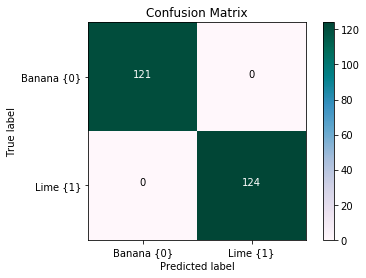

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [87]:
two_classes = []
two_classes_id = []
for i in range(0, label_ids.shape[0]):
    if(label_ids[i]!=2):
        two_classes.append(pca_result[i,:])
        two_classes_id.append(label_ids[i])
two_classes_id = np.array(two_classes_id)
two_classes = np.array(two_classes)

X_train, X_test, y_train, y_test = train_test_split(two_classes, two_classes_id, test_size=0.25, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
predictions = clf.predict(X_test)

precision = accuracy_score(predictions, y_test) * 100
print("Accuracy with LogisticRegressionCV: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix)

## Multi-class Logisitic Regression

Accuracy with LogisticRegressionCV: 100.000000


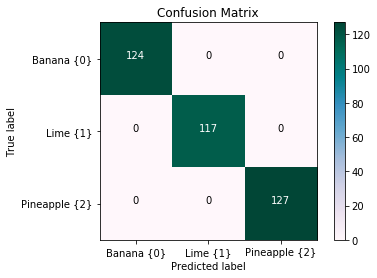

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [88]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X_train, y_train)
predictions = clf.predict(X_test)

precision = accuracy_score(predictions, y_test) * 100
print("Accuracy with LogisticRegressionCV: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)

# Classification Trees

In [89]:
from sklearn.tree import DecisionTreeClassifier
import numpy.linalg as LA
DT = DecisionTreeClassifier(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

Accuracy with Classification Trees: 99.456522


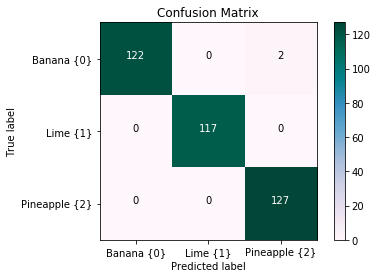

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [90]:
DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)
precision = accuracy_score(y_pred, y_test) * 100
print("Accuracy with Classification Trees: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)
error = LA.norm(y_test-y_pred)**2/y_test.shape[0]

In [91]:
def DTClassifier(X_train,X_test,y_train,y_test):
    DT = DecisionTreeClassifier(random_state=0)
    DT.fit(X_train,y_train)
    y_pred = DT.predict(X_test)
    precision = accuracy_score(y_pred, y_test) * 100
    print("Accuracy with Classification Trees: {0:.6f}".format(precision))
    return precision

In [99]:
from sklearn.model_selection import KFold
X = pca_result
y = label_ids
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
print(kf)
X_tr_l = []
X_test_l = []
y_tr_l = []
y_test_l = []
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_tr_l.append(X_train)
    X_test_l.append(X_test)
    y_tr_l.append(y_train)
    y_test_l.append(y_test)

KFold(n_splits=5, random_state=None, shuffle=True)


In [100]:
accuracy = []
for i in range(len(X_tr_l)):
    accuracy.append(DTClassifier(X_tr_l[i],X_test_l[i],y_tr_l[i],y_test_l[i]))
    print("running")
idx = np.argmax(accuracy)
X_train = X_tr_l[idx]
X_test = X_test_l[idx]
y_train = y_tr_l[idx]
y_test= y_test_l[idx]
print("Best fold is: ",idx+1)

Accuracy with Classification Trees: 99.659864
running
Accuracy with Classification Trees: 99.319728
running
Accuracy with Classification Trees: 100.000000
running
Accuracy with Classification Trees: 99.659864
running
Accuracy with Classification Trees: 100.000000
running
Best fold is:  2


Validation Accuracy with Classification Trees: 99.799197


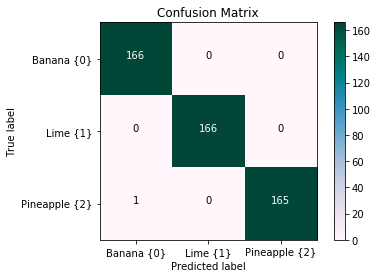

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [58]:
val_pred = DT.predict(val_pca_res)
precision = accuracy_score(val_pred, val_label_ids) * 100
print("Validation Accuracy with Classification Trees: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_label_ids,val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)

### Random Forest

Accuracy with RandomForest: 100.000000


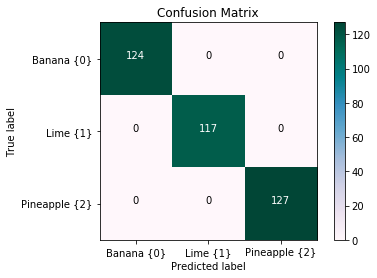

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [59]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10)
forest = forest.fit(X_train, y_train)
test_predictions = forest.predict(X_test)
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,test_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)

Validation Accuracy with Random Forest: 100.000000


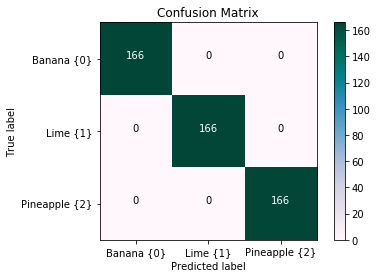

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [60]:
val_predictions = forest.predict(val_pca_res)
precision = accuracy_score(val_predictions, val_label_ids) * 100
print("Validation Accuracy with Random Forest: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_label_ids,val_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)